<a href="https://colab.research.google.com/github/ammobam/Display_SensorData/blob/main/210728_%EB%82%98%EB%AC%B4%ED%94%8C%EB%9E%98%EB%8B%9B_%EB%94%94%EC%8A%A4%ED%94%8C%EB%A0%88%EC%9D%B4_%EC%84%BC%EC%84%9C%EB%8D%B0%EC%9D%B4%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Github project
- 조장이 만든 프로젝트 레포지토리 Fork 해오기
- 각자 branch 생성해서 작업
- 작업 후 pull request 요청
- 프로젝트 관리자가 승인하고 merge
- 다른 작업자는 새로 fork해와서 확인 가능함

## 주의사항
- 변수명 통일 필요함

# 디스플레이 생산라인 센서 데이터 분석

## 주제 : 불량품에 영향을 주는 요인 찾기
- 결과 : "ㅇㅇ센서에서 ㅁㅁ면 불량품"
1. 주요 요인 피처 5개 추출
2. 불량품/양품 구분하는 모델도 찾아야 함


- 머신러닝 이용


## 데이터 불러오기

In [1]:
# 데이터 불러오기
import pandas as pd
df_origin = pd.read_csv('/content/drive/MyDrive/나무플래닛/1. 데이터_디스플레이/factory_glass_2016.zip', encoding='cp949')

# 데이터 확인
df_origin.info()
    ## 데이터는 대부분 숫자형, 1개의 문자형(object) 데이터
    ## 841개 컬럼 * 8145개 행

df_origin.head(5)
## 각 행은 한 시간 간격으로 생산한 디스플레이의 센서 데이터 ??

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8145 entries, 0 to 8144
Columns: 841 entries, dat...date.name. to R.Vac
dtypes: float64(834), int64(6), object(1)
memory usage: 52.3+ MB


,dat...date.name.,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,LEHR.DRV.MTR..M7.2.SPD.1WSI40111,LEHR.DRV.MTR..M8.1.SPD.1WSI40112,LEHR.DRV.MTR..M8.2.SPD.1WSI40113,LEHR.DRV.MTR..M9.1.SPD.1WSI40114,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,DRIVE.MOTOR.M10.1.SPEED.1WSI40116,LEHR.DRV.MTR..M10.2.SPD.1WSI40117,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,DRIVE.MOTOR.M11.2.SPEED.1WSI40119,LEHR.DRV.MTR..M12.1.SPD.1WSI40120,LEHR.DRV.MTR..M12.2.SPD.1WSI40121,LEHR.DRV.MTR..M13.1.SPD.1WSI40122,LEHR.DRV.MTR..M13.2.SPD.1WSI40123,LEHR.DRV.MTR..M14.1.SPD.1WSI40124,LEHR.DRV.MTR..M14.2.SPD.1WSI40125,LEHR.DRV.MTR..M15.1.SPD.1WSI40126,LEHR.DRV.MTR..M15.2.SPD.1WSI40127,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,DRIVE.MOTOR.M16.2.SPEED.1WSI40129,LEHR.DRV.MTR..M17.1.SPD.1WSI40130,LEHR.DRV.MTR..M17.2.SPD.1WSI40131,LEHR.DRV.MTR..M18.1.SPD.1WSI40132,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,DRIVE.MOTOR.M19.1.SPEED.1WSI40134,LEHR.DRV.MTR..M19.2.SPD.1WSI40135,X1WOS45101_PV,X1WOS45102_PV,X1WOS45103_PV,X1WOS45104_PV,...,S_C1_C2_L_L,S_C1_C2_L_R,S_C2_C3_U_L,S_C2_C3_U_R,S_C2_C3_L_L,S_C2_C3_L_R,S_C3_C4_U_L,S_C3_C4_U_R,S_C3_C4_L_L,S_C3_C4_L_R,S_AB1_AB11_L,S_AB1_AB11_R,S_AB11_AB7_L,S_AB11_AB7_R,S_AB7_C4_L,S_AB7_C4_R,S_C4_RET_L,S_C4_RET_R,S_RET_F_L,S_RET_F_R,STD_U_L,STD_U_R,STD_L_L,STD_L_R,STD_GLS_L,STD_GLS_R,투입.LEFT.,투입.RIGHT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
0,2016-01-01 07,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,...,-0.195736,0.706941,1.477203,0.410847,0.491620,0.942180,2.776941,2.492437,2.060406,2.612283,1.726404,1.461145,-1.192642,-1.134471,2.599429,2.690433,-0.365598,-0.659319,-1.963403,-1.621407,0.523950,1.951349,2.248106,2.767676,3.012706,3.069007,80,74,2,5,8,3,11.69,8.75,14.86,11.69,0.025,0.063,0.108,0.041
1,2016-01-01 08,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,...,-0.500742,0.822657,1.495204,0.397591,0.587871,0.938186,2.888919,2.573187,2.161149,2.664726,1.682081,1.414518,-1.109125,-1.042269,2.588703,2.654307,-0.348979,-0.560103,-1.978936,-1.810022,0.566521,2.010125,2.364418,2.842630,3.022998,3.069274,92,75,0,2,10,0,7.19,2.17,13.33,7.19,0.000,0.022,0.133,0.000
2,2016-01-01 09,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,...,-0.164556,0.962210,1.552127,0.460702,0.397216,0.843443,2.868644,2.486441,2.183298,2.638130,1.632955,1.359022,-0.986580,-0.928583,2.550175,2.606185,-0.456071,-0.644073,-1.878611,-1.742395,0.545936,2.002820,2.397034,2.817728,2.936967,2.969952,64,66,1,4,0,0,3.85,7.81,0.00,3.85,0.016,0.063,0.000,0.000
3,2016-01-01 10,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,

In [2]:
# 데이터 확인
df_origin.iloc[:, -10:].head(5)

,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
0,8,3,11.69,8.75,14.86,11.69,0.025,0.063,0.108,0.041
1,10,0,7.19,2.17,13.33,7.19,0.000,0.022,0.133,0.000
2,0,0,3.85,7.81,0.00,3.85,0.016,0.063,0.000,0.000
3,0,0,4.96,10.29,0.00,4.96,0.000,0.103,0.000,0.000
4,0,0,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000


## 이름이 비슷한 컬럼끼리 상관관계 확인
* 데이터의 컬럼이름을 확인해보니 앞 10글자가 같은 데이터가 다수 존재함
* 이름이 비슷한 컬럼들은 서로 종속성이 높은 데이터일 것으로 생각함 --> 확인

### 다중공선성
* 머신러닝에서 피처간 종속성이 높은 경우 다중공선성 문제가 발생함
* 다중공선성이 높은 피처들의 영향력이 크게 반영되기 때문에 회귀모델에 부정적인 영향을 줌
* 따라서 피처간 상관계수가 높은 경우 해당 피처의 영향력을 낮게 반영하도록 해야 함
    * 상관계수 0.4 이상 : 약한 상관관계가 있음
    * 상관계수 0.6 이상 : 상관관계가 있음
    * 상관계수 0.7 이상 : 강한 상관관계가 있음


### 컬럼명-컬럼인덱스 딕셔너리 만들기

In [3]:
# 컬럼이름 리스트로 만들기
#print(type(df_origin.columns)) # 인덱스
name_list = df_origin.columns.tolist()

# 컬럼리스트 중 dat...date.name. 컬럼 제거
## 숫자가 아닌 문자 데이터. 상관관계 연산 불가능
name_list.remove('dat...date.name.')
#print(name_list)

# 컬럼이름에서 앞의 10글자만 모은 리스트 생성
name_list_10=[]
for name in name_list:
    name = str(name)[:10]
    name_list_10.append(name)
#print(name_list_10)

In [4]:
# 컬럼이름(10글자)을 키, 각 컬럼의 인덱스를 값으로 하는 딕셔너리 생성
## 컬럼이름(10글자)가 동일한 컬럼의 인덱스를 모아 볼 수 있으므로
## 이름이 유사한 컬럼 집단의 개수, 각 집단에 속하는 컬럼의 수를 파악하기 쉬워짐

# 빈 딕셔너리 생성
name_dict = {}

# 인덱스, 컬럼이름에 대해 반복
for index, key in enumerate(name_list_10):
    
    #print(index) # 0-839까지. 원래 0번 컬럼인 'dat...date.name.' 삭제해서 컬럼 840개임    ##??
    # 만약 key가 딕셔너리에 없으면 키, 인덱스 생성
    if key not in name_dict:
        name_dict[key] = [index]
        ## 딕셔너리에 넣을 때 int가 아닌 list로 넣어야 함
    
    # 만약 key가 딕셔너리에 있으면 인덱스 추가
    else :
        name_dict[key].append(index)

# 확인
print(name_dict)
#name_dict.keys()
#name_dict.items()

{'LIFT.OUT.R': [0, 1, 2, 263, 264, 265, 298, 299, 300], 'LEHR.DRV.M': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 279, 280, 282, 283, 284, 285, 286, 287, 288, 289, 290, 292, 293, 294, 295, 297, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332], 'DRIVE.MOTO': [15, 18, 28, 33, 278, 281, 291, 296], 'X1WOS45101': [35, 333], 'X1WOS45102': [36, 334], 'X1WOS45103': [37, 335], 'X1WOS45104': [38, 336], 'X1WOS45105': [39, 337], 'X1WOS45106': [40, 338], 'X1WOS45107': [41, 339], 'X1WOS45108': [42, 340], 'X1WOS45109': [43, 341], 'X1WOS45110': [44, 342], 'DCS_Offset': [45, 46, 47, 48, 49, 50, 51, 52, 53, 343, 344, 345, 346, 347, 348, 349, 350, 351], 'DAMP.POSIT': [54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425], 

In [5]:
# key(컬럼집단) 개수 : 246개
len(name_dict)

245

### 컬럼집단('ATM.FLOW.S') 별 컬럼 간 상관계수 확인

In [6]:
# 'ATM.FLOW.S' 로 시작하는 컬럼 간의 상관계수 확인하기
## 만약 이름이 유사한 컬럼 간 종속성이 높다면
## 해당 컬럼 집단에서 하나만 골라 대표로 하고 전체 데이터에 대해 상관계수를 확인할 것

# 'ATM.FLOW.S' 컬럼집단의 컬럼 인덱스 리스트
col_atm = name_dict['ATM.FLOW.S']

# 데이터에서 해당 컬럼만 추출하여 저장하기
df = df_origin.iloc[:, col_atm]

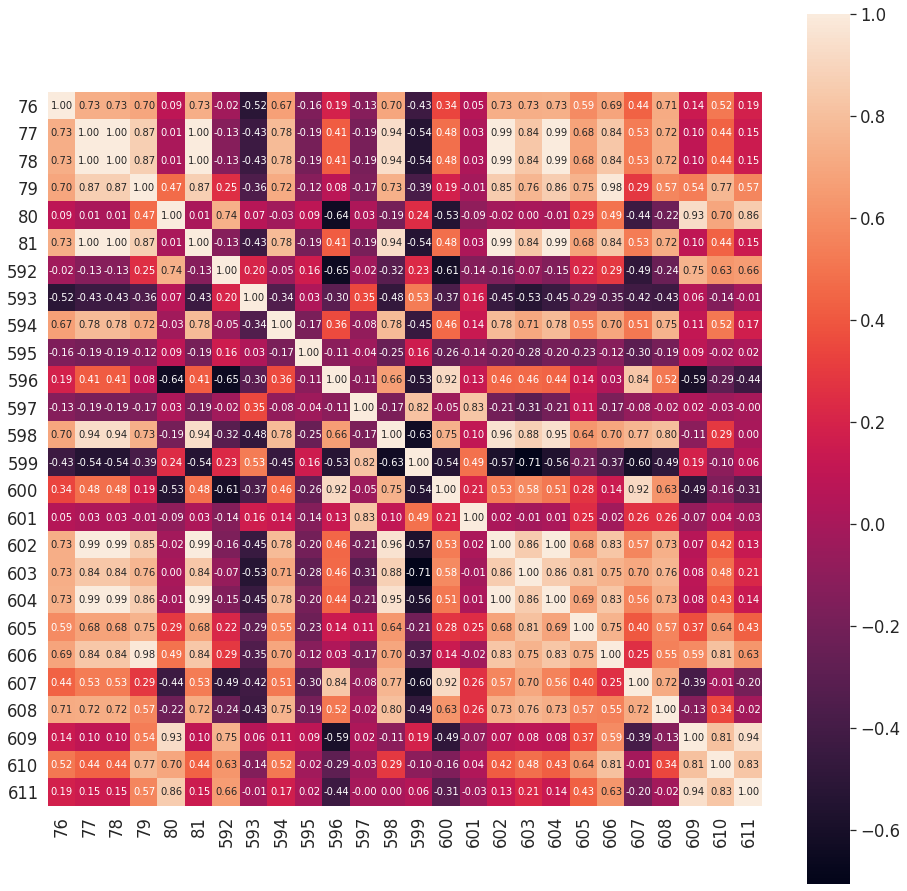

In [7]:
# 상관계수 데이터프레임을 배열로 저장
corr_array = df.corr().to_numpy()
#print(corr_array.shape)    # (26,26)

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
sns.set(font_scale=1.5)
sns.heatmap(corr_array, cbar=True, square=True, fmt='.2f', annot=True,
           annot_kws={'size':10}, yticklabels=col_atm, xticklabels=col_atm)
plt.show()

### 중간결론
1. 'ATM.FLOW.S'로 시작하는 컬럼집단의 상관관계 확인 결과
- 'ATM.FLOW.S'
- 00, 500, 600 번대 센서데이터 있음
- 상관계수가 0.6 이상으로 상관관계 높은 컬럼이 다수 존재함

---
<아래 '종속성이 높은 컬럼을 제외'하는 작업은 안 하기로 결정함>
* 일부 컬럼간의 상관계수만 확인하고 종속성 높은 컬럼을 제거하는 것은 비약이 심함
* A, B, C, ..., X, Y, Z의 컬럼이 있을 때
* A가 B, C와의 종속성은 높지만 X, Y, Z와는 독립적일 때,
* A를 제외하는 것은 데이터의 손실이 큼
* 모든 컬럼 841*841을 비교하여 모든 컬럼에서 상관계수가 높게 나오지 않으면 제거하기 어려움
---
### !! 종속성 높은 컬럼을 제외한 컬럼이름 리스트 만들기
* 모든 key(컬럼집단)에 대해 종속성 높은 컬럼을 제외한 컬럼이름 리스트 만들기
1. 각 컬럼 집단 내 상관계수를 구함
2. 피처간 종속성 낮은 컬럼이름 리스트 생성
    - 종속성 낮은 컬럼 모두
    - 종속성 높은 컬럼 중 1개 선택
    - 기준 : 상관관계 0.6 이상이면 종속성 높음으로 이해 (먼저 등장한 컬럼을 선택)
3. 해당 컬럼들로 데이터 탐색 진행
    - 상관관계 분석, 기술통계량 분석 수행

In [8]:
# 딕셔너리 키(컬럼집단) 이름을 리스트로 저장
key_list = []
for key in name_dict.keys():
    key_list.append(key)
print(key_list)

['LIFT.OUT.R', 'LEHR.DRV.M', 'DRIVE.MOTO', 'X1WOS45101', 'X1WOS45102', 'X1WOS45103', 'X1WOS45104', 'X1WOS45105', 'X1WOS45106', 'X1WOS45107', 'X1WOS45108', 'X1WOS45109', 'X1WOS45110', 'DCS_Offset', 'DAMP.POSIT', 'DB.N2.SCRE', 'N2.TO.EA13', 'ROOF.HEATI', 'ATM.FLOW.S', 'SEC11.N2.1', 'SEC11.N2.H', 'cluster', 'ML.Speed', 'Ribbon.Spe', 'Gross.widt', 'Left.edge', 'Right.edge', 'UPPER.AB1.', 'LOWER.AB1.', 'UPPER.AB2.', 'LOWER.AB2.', 'UPPER.AB3.', 'LOWER.AB3.', 'UPPER.AB4.', 'LOWER.AB4.', 'UPPER.AB5.', 'LOWER.AB5.', 'UPPER.AB6.', 'LOWER.AB6.', 'UPPER.AB7.', 'LOWER.AB7.', 'UPPER.AB8.', 'LOWER.AB8.', 'UPPER.AB9.', 'LOWER.AB9.', 'UPPER.AB10', 'LOWER.AB10', 'UPPER.AB11', 'LOWER.AB11', 'UPPER.C1..', 'LOWER.C1..', 'UPPER.C2..', 'LOWER.C2..', 'UPPER.C3..', 'LOWER.C3..', 'UPPER.C4..', 'LOWER.C4..', 'UPPER.RET.', 'TMP.GLASS.', 'TMP.TIN..B', 'X.10.BAY.L', 'X.10.BAY.R', 'X.1.BAY.LE', 'X.1.BAY.RI', 'X.7.BAY.LE', 'X.7.BAY.RI', 'X.1.LEHR.S', 'X.1.LEHR.O', 'X.2.LEHR.S', 'X.2.LEHR.O', 'CASHING.CO', 'RET.AMBIAN

In [9]:
# 상관계수 데이터프레임 생성 함수
# 키를 입력하면 해당 키에 속하는 컬럼간 상관계수를 데이터프레임로 생성

def make_corr_df(key):

    # 컬럼 인덱스 리스트
    col_idx = name_dict[key]
    #print(col_idx)

    # 데이터에서 해당 컬럼만 추출하여 저장하기
    df_corr = df_origin.iloc[:, col_idx]

    # 컬럼 간 상관계수 구하기
    df_corr = df_corr.corr()

    return df_corr


# 상관계수 시각화 함수
# 키를 입력하면 해당 키에 속하는 컬럼간 상관계수 히트맵 생성
import seaborn as sns
import matplotlib.pyplot as plt

def make_heatmap(key):
    
    # 컬럼 인덱스 리스트
    col_idx = name_dict[key]
    
    # 상관계수 데이터프레임 생성
    df_corr = make_corr_df(key)

    # 상관계수에 절대값 취하기
    df_corr = df_corr.abs()
    
    # 상관계수 데이터프레임을 배열로 저장
    corr_array = df_corr.to_numpy()

    # 상관계수 히트맵 그리기
    plt.figure(figsize=(14,14))
    sns.set(font_scale=1.5)
    sns.heatmap(corr_array, cbar=True, square=True, fmt='.2f', annot=True, 
                annot_kws={'size':10}, yticklabels=col_idx, xticklabels=col_idx)
    plt.show()

In [10]:
# make_corr 함수 확인
df_corr = make_corr_df('LIFT.OUT.R')
df_corr.describe()

,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,UPPER.RET..Z218.TMP.1TIC42601.PV,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101.1,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102.1,LEHR.DRV.MTR..M19.2.SPD.1WSI40135.1,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV
count,7.000000,7.000000,0.0,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.664335,0.671524,NaN,0.670041,0.670300,0.670682,0.189239,0.134128
std,0.564266,0.552300,NaN,0.557962,0.557493,0.555521,0.508375,0.545904
min,-0.199014,-0.175137,NaN,-0.184831,-0.183871,-0.180350,-0.123036,-0.199014
25%,0.433689,0.446647,NaN,0.442237,0.442670,0.443536,-0.106819,-0.184351
50%,0.991691,0.991978,NaN,0.992003,0.991978,0.990710,-0.103342,-0.180350
75%,0.995145,0.995266,NaN,0.999319,0.999328,0.998672,0.382344,0.343483
max,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000


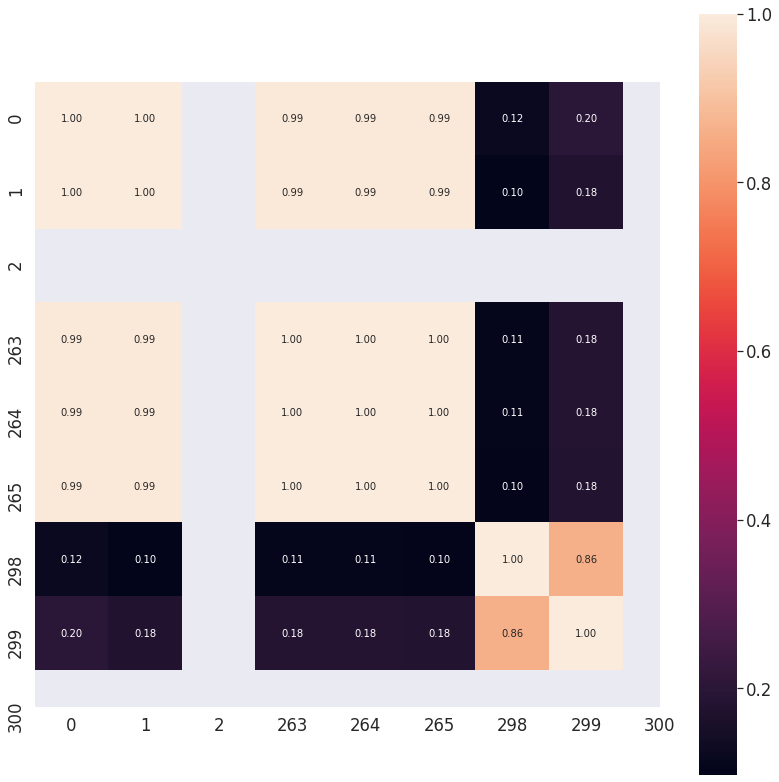

In [11]:
# make_heatmap 함수 확인
make_heatmap('LIFT.OUT.R')
    #?? 중간에 빈 인덱스 2번 컬럼 : UPPER.RET..Z218.TMP.1TIC42601.PV 은 NaN값임
#make_heatmap('LEHR.DRV.M')
#make_heatmap('DRIVE.MOTO')

In [12]:
df_corr = make_corr_df('DRIVE.MOTO')
df_corr


,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,LEHR.DRV.MTR..M9.2.SPD.1WSI40115.1,LEHR.DRV.MTR..M11.1.SPD.1WSI40118.1,LEHR.DRV.MTR..M16.1.SPD.1WSI40128.1,LEHR.DRV.MTR..M18.2.SPD.1WSI40133.1
LEHR.DRV.MTR..M9.2.SPD.1WSI40115,1.000000,0.946620,0.960656,0.997309,0.990362,0.990314,0.990784,0.989808
LEHR.DRV.MTR..M11.1.SPD.1WSI40118,0.946620,1.000000,0.981734,0.947067,0.938184,0.942861,0.942913,0.938075
LEHR.DRV.MTR..M16.1.SPD.1WSI40128,0.960656,0.981734,1.000000,0.962018,0.953748,0.957217,0.957912,0.953788
LEHR.DRV.MTR..M18.2.SPD.1WSI40133,0.997309,0.947067,0.962018,1.000000,0.990829,0.990930,0.991387,0.990514
LEHR.DRV.MTR..M9.2.SPD.1WSI40115.1,0.990362,0.938184,0.953748,0.990829,1.000000,0.995014,0.996210,0.999512
LEHR.DRV.MTR..M11.1.SPD.1WSI40118.1,0.990314,0.942861,0.957217,0.990930,0.995014,1.000000,0.999588,0.994590
LEHR.DRV.MTR..M16.1.SPD.1WSI40128.1,0.990784,0.942913,0.957912,0.991387,0.996210,0.999588,1.000000,0.995790
LEHR.DRV.MTR..M18.2.SPD.1WSI40133.1,0.989808,0.938075,0.953788,0.990514,0.999512,0.994590,0.995790,1.000000


In [13]:
# 각 컬럼집단(키) 내 컬럼간 상관계수를 구하고
df_corr = make_corr_df('DRIVE.MOTO')
#df_corr.describe()

# 상관계수의 절대값이 0.6 이상인 컬럼 중 1개만 선택함 (먼저 등장한 컬럼을 선택)

# 선택한 컬럼을 저장할 리스트 생성
col_select=[]

# 상관계수 컬럼의 길이
df_corr_len = len(df_corr)

# 컬럼집단 안의 모든 컬럼과 비교해서 상관계수가 0.6보다 작은 컬럼이름의 리스트 만들기
# 각 컬럼 길이만큼 반복

names = df_corr.columns

li = []
for i in names:
    if i in li:
        continue
    x = df_corr[i].index
    k = 0
    for v, index in zip(df_corr[i], x):
        k = k + 1
        if v > 0.6:
            if index != i:
                if index not in li:
                    li.append(i)
                    break
    else:
        if i not in li:
            li.append(i)

print(li)         



['LEHR.DRV.MTR..M9.2.SPD.1WSI40115', 'LEHR.DRV.MTR..M11.1.SPD.1WSI40118', 'LEHR.DRV.MTR..M16.1.SPD.1WSI40128', 'LEHR.DRV.MTR..M18.2.SPD.1WSI40133', 'LEHR.DRV.MTR..M9.2.SPD.1WSI40115.1', 'LEHR.DRV.MTR..M11.1.SPD.1WSI40118.1', 'LEHR.DRV.MTR..M16.1.SPD.1WSI40128.1', 'LEHR.DRV.MTR..M18.2.SPD.1WSI40133.1']


In [14]:
seri = df_corr.iloc[:, i]
    #print("------------------------------\n", seri)

    # 상관계수가 0.6 이하인 컬럼을 고르고, 해당 컬럼명을 리스트 저장
    col = seri[seri<0.6].index
    
    for j in col:
        col_select.append(j)

    # 상관계수가 0.6 이상인 컬럼 중 1개의 컬럼명을 리스트 저장
    col_select.append(seri[seri>0.6].index[0])

# 확인
col_select

IndentationError: ignored

In [ ]:
# 확인
for i in range(seri_len):
    seri = df_corr.iloc[:, i]
    print("------------------------------\n", seri)

    print("------------------------------", (seri<0.6))
    #print("------------------------------", type(seri<0.6))

In [ ]:
# 각 컬럼집단(키) 내 종속성 높은 컬럼들은 1개만 추가함
def key_col_select(key):
    #print(key)
    df_corr = make_corr_df(key)
    #print("1", df_corr)
    # 상관계수의 절대값이 0.6 이상인 컬럼 중 1개만 선택함 (먼저 등장한 컬럼을 선택)

    # 선택한 컬럼을 저장할 리스트 생성
    col_select=[]

    # 상관계수 컬럼의 길이
    seri_len = len(df_corr)

    # 독립적인 컬럼이름 리스트 만들기
    # 각 컬럼 길이만큼 반복
    for i in range(seri_len):
        # 데이터 1줄(컬럼)을 시리즈로 저장
        seri = df_corr.iloc[:, i]
        #print("------------------------------\n", seri)

        # 상관계수가 0.6 이하인 컬럼을 고르고, 해당 컬럼명을 리스트 저장
        col = seri[seri<0.6].index

        for j in col:
            col_select.append(j)

        # 상관계수가 0.6 이상인 컬럼 중 1개의 컬럼명을 리스트 저장
        for k in seri[seri>0.6].index:
            print()
            col_select.append(seri[seri>0.6].index[0])
            break
    return col_select

In [ ]:
# 확인
key_col_select('LIFT.OUT.R')

In [ ]:
# 종속성 높은 컬럼 제거한 컬럼명 리스트
# 딕셔너리의 각 키에 대해서 반복 수행
col_select_list=[]
for key in key_list:
    col_select_list = col_select_list.__add__(key_col_select(key))

In [ ]:
len(col_select_list)

In [ ]:
# 컬럼명 리스트
# 이름 앞글자 10개가 비슷한 컬럼 간의 종속성이 높은 컬럼 삭제함
# 592개의 컬럼에 대해 전처리 수행하고, 기술통계, 상관관계 등 데이터 탐색 진행할 예정
print(col_select_list)

In [ ]:
# 각 컬럼집단(키) 내 컬럼간 상관계수를 구하고
df_corr = make_corr_df('DRIVE.MOTO')
#df_corr.describe()

# 상관계수의 절대값이 0.6 이상인 컬럼 중 1개만 선택함 (먼저 등장한 컬럼을 선택)

# 선택한 컬럼을 저장할 리스트 생성
col_select=[]

# 상관계수 컬럼의 길이
seri_len = len(df_abs)

# 독립적인 컬럼이름 리스트 만들기
# 각 컬럼 길이만큼 반복
for i in range(seri_len):
    # 각 컬럼을 시리즈로 저장
    seri = df_abs.iloc[:, i]
    #print("------------------------------\n", seri)

    # 상관계수가 0.6 이하인 컬럼을 고르고, 해당 컬럼명을 리스트 저장
    col = seri[seri<0.6].index
    
    for j in col:
        col_select.append(j)

    # 상관계수가 0.6 이상인 컬럼 중 1개의 컬럼명을 리스트 저장
col_select.append(seri[seri>0.6].index[0])

# 확인
col_select

## 데이터 탐색(EDA)
* 데이터 탐색
- 각종 통계자료 수집
	-- 도메인에 대한 이해 필요없음. 찾지 말 것.
	-- 기술통계량 :
		컬럼 개수
		불량/양품 개수,
		평균, 표준편차 등...

- 요인 분석 방법 알아오기
	-- 주성분 분석
	-- 상관계수
	-- 다중공선성
		다중 공선성 파악은 VIF(분산 팽창 요인)을 확인
	-- 분류/회귀 모형
		coef_
		feature_importances_